# Cloud detection using Fastai2 
### *** This version is trained with 50% version of the two datasets and 10 epochs
The objective of this notebook is to show how to use the recently released Fastai2 library for the cloud detection task.<br>
The Fastai2 library has been launched 21/08/2020, as well as a book and a brand new 2020 course. More information can be found in their webpage: https://www.fast.ai/2020/08/21/fastai2-launch/.

For a brief explanation on how to use the Fastai2 data blocks to create processing pipelines, please refer to my story on TowardsDataScience: https://towardsdatascience.com/how-to-create-a-datablock-for-multispectral-satellite-image-segmentation-with-the-fastai-v2-bc5e82f4eb5

One difference to this dataset is that it keeps the bands in separate folders.

In this notebook we will see how to:
- Install fastai 2 into kaggle and use the GPU
- Create a customized datablock in Fastai2 to collate files from different folders into a single output
- Join files from two different Kaggle datasets (38 cloud and 98 cloud)
- Find the best Learning Rate using the LR-Finder
- Train a U-Net architecture to detect clouds
- Evaluate the model

We will not cover the data itself, because there is already a good EDA for this dataset:
https://www.kaggle.com/polavr/cloud95-exploracion-de-datos

So, Let's go:

As fastai2 is not yet default in Kaggle, our first task is to install the library and its dependencies.


In [ ]:
# update torch and torch vision
!pip install -q torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

In [ ]:
# install kornia, we will give it a try to accelarate our preprocessing
!pip install -q --upgrade kornia
!pip install -q allennlp==1.1.0.rc4

In [ ]:
# and install fastai2
!pip install -q --upgrade fastai

In [ ]:
# Now, let's check the installed libraries

import torch
print(torch.__version__)
print(torch.cuda.is_available())

import fastai
print(fastai.__version__)

from fastai.vision.all import *

In [ ]:
# other imports
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

## Opening the images

In the medium story I created a new class MSTensorImage to keep basic functionalities of Fastai2. However, to keep things really simple here, I will just create a function tha opens the .TIF file (TensorImages doesn't support it) and another function to collate the 4 bands.

In [ ]:
def open_tif(fn, chnls=None, cls=torch.Tensor):
    im = (np.array(Image.open(fn))).astype('float32')
    return cls(im)

In [ ]:
# Just checking our function
base_path = Path('../input/95cloud-cloud-segmentation-on-satellite-images/95-cloud_training_only_additional_to38-cloud/train_red_additional_to38cloud')

open_tif(base_path/'red_patch_100_5_by_16_LC08_L1TP_035031_20160120_20170224_01_T1.TIF').shape

In [ ]:
# Note that we can pass the desired output class and it casts automatically. Here we receive a TensorImage
open_tif(base_path/'red_patch_100_5_by_16_LC08_L1TP_035031_20160120_20170224_01_T1.TIF', cls=TensorImage)

## Opening the masks
For the masks, we will use the TensorMask class already defined, like so:

In [ ]:
# Note that we can cast to the desired class implicitly or explicitly
mask = TensorMask(open_tif('../input/95cloud-cloud-segmentation-on-satellite-images/95-cloud_training_only_additional_to38-cloud/train_gt_additional_to38cloud/gt_patch_100_5_by_16_LC08_L1TP_030034_20170815_20170825_01_T1.TIF'))
mask.show()

## Creating the datablock
Now that we already have a way to open both images (and cast them to the desired class) we will create the pipeline for Xs and Ys. This picture summarizes how the DataBlock works.
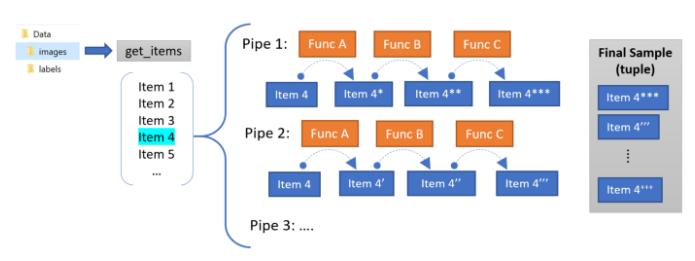
As I did in the Cloud-38 notebook, I will point the items to the red folder, and then derive the other bands from there.

In [ ]:
# get items from both datasets
items_95 = get_files(base_path, extensions='.TIF')
items_38 = get_files('/kaggle/input/38cloud-cloud-segmentation-in-satellite-images/38-Cloud_training/train_red/', extensions='.TIF')
all_items = items_95 + items_38

In [ ]:
# now select just the non empty ones
n_empty = pd.read_csv('/kaggle/input/95cloud-cloud-segmentation-on-satellite-images/95-cloud_training_only_additional_to38-cloud/training_patches_95-cloud_nonempty.csv')

def non_empty(item):
    
    if n_empty.name.isin([item.stem[4:]]).any():
        return True
    else:
        return False
    
items_mask = all_items.map(non_empty)
items = all_items[items_mask]
items

### Image Block
As the files are in separate folders and we want to create a single 4 channels tensor to train with, our first challenge is to collate the images. We will need 2 separate functions:
- One function to get the base filename and return all 4 filenames
- Another function to receive this list with 4 filenames and open it into a single tensor

Let's try it:

In [ ]:
# The map_filename function makes it easier to map from one folder to another by replacing strings
def map_filename(base_fn, str1, str2):
    return Path(str(base_fn).replace(str1, str2))

def get_filenames(red_filename):
    return [red_filename,
            map_filename(red_filename, str1='red', str2='green'),
            map_filename(red_filename, str1='red', str2='blue'),
            map_filename(red_filename, str1='red', str2='nir'),
           ]


# the open multi-spectral tif function will be in charge of opening the separate tifs and collate them
def open_ms_tif(files):
    ms_img = None
    
    for path in files:
        img = open_tif(path)
        
        if ms_img is None:
            ms_img = img[None]
        else:
            ms_img = np.concatenate([ms_img, img[None]], axis=0)
            
    return TensorImage(ms_img)
    

# Check if it is mapping correcly
for path in get_filenames(items[0]):
    assert path.exists() == True

# check if we can open an image
open_ms_tif(get_filenames(items[0])).shape

In [ ]:
ImageBlock = TransformBlock(type_tfms=[get_filenames,
                                       open_ms_tif, 
                                       lambda x: x/10000
                                      ])

### MaskBlock (Y or Target)
For the mask block, we can use the get_y function to map the filename (red) to the gt filename.

In [ ]:
MaskBlock = TransformBlock(type_tfms=[partial(open_tif, cls=TensorMask),
                                      AddMaskCodes(codes=['clear', 'cloudy'])
                                     ])

## Combining the blocks into a DataBlock

In [ ]:
# in this example, we don't need to specify the get_items function 
# because we will pass the list of files as the source
db = DataBlock(blocks=(ImageBlock, MaskBlock),
               get_y = partial(map_filename, str1='red', str2='gt'),
               splitter=RandomSplitter(valid_pct=0.5)
              )

# We will call db.summary to see if everything goes well
# Note that our final sample is composed by a tuple (X, Y) as we wanted
%time db.summary(source=items)

## Create a dataloader

In [ ]:
dl = db.dataloaders(source=items, bs=12) #, num_workers=0)

# now, let's check if the batch is being created correctly
batch = dl.one_batch()
batch[0].shape, batch[1].shape

# Remember that we cannot use visual funcs like show_batch as the TensorImage does not support multi channel images
# for that, we have to subclass the TensorImage as I explained in Medium:
# How to create a DataBlock for Multispectral Satellite Image Segmentation with the Fastai-v2
# https://towardsdatascience.com/how-to-create-a-datablock-for-multispectral-satellite-image-segmentation-with-the-fastai-v2-bc5e82f4eb5

## Train a model

In [ ]:
def acc_metric(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1)==target).float().mean()

def loss_fn(pred, targ):
    targ[targ==255] = 1
    return torch.nn.functional.cross_entropy(pred, targ.squeeze(1).type(torch.long))

learn = unet_learner(dl, resnet18, n_in=4, n_out=2, pretrained=False, loss_func=loss_fn, metrics=acc_metric)

In [ ]:
# At this notebook version we are starting from a previously saved checkpoint
# We will then, load the previous weights and train for 5 more epochs

# The final objective is to compare the final accuracy, with the accuracy introducing augmentations
try:
    learn.load('/kaggle/input/remotesensing-fastai2-simpletraining/models/95_cloud-resnet18-50-10epochs.learner')
    print('Loaded sucessfully')
    learn.fit_one_cycle(5, lr_max=1e-4, wd=1e-2)
    learn.save('./95_cloud-resnet18-50-10epochs.learner')
except:
    
    print('failed loading checkpoint')
    

# learn.lr_find()

In [ ]:
# And we save our first model to test it later
